# Effective counterdiabatic gate for different sets of parameters

This notebook constructs the effective counterdiabatic modified Saffman gate. This is based on the QuTip Python package and it should be noted that most functions are to be found in the "helpers.py" file.

In [1]:
#Package importation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

from qutip import *
from scipy.integrate import quad
from helpers import *

qutip.settings.auto_tidyup = False

## Test evolution of $H_{eCD}$ for initial Bell state

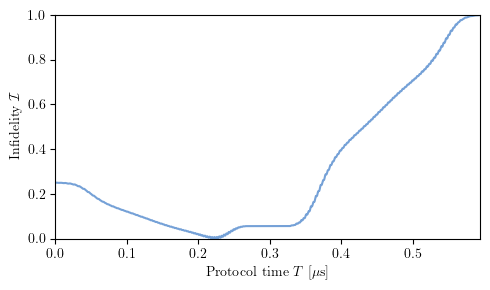

In [2]:
#Define parameters
T, steps  = 0.54, 1000
Ttot, tau = T + T/10, 0.175*T
iters = 5000
Omax, Dmax = 23*2*np.pi, 17*2*np.pi
V = 2500*2*np.pi
psi_in, psi_exp = (e0+e4).unit(), (e0-e4).unit()


# Define arrays and dictionaries
args   = {"T":T, "Omax":Omax, "Dmax":Dmax, "tau":tau, 'T2':T/10, 'V':V, 'omg':0}
tvals  = np.linspace(0, Ttot, steps)
itvals = np.linspace(0, Ttot, iters)

# Get Hamiltonians
H_0    = fH_0(V, args)
dt_H_0 = fdt_H_0(V, args)
H_V    = M5*V
f1, f2 = f1_f2_num(H_0, dt_H_0, iters, args)

# Restrict eCD pulse to Omega_max and define H_E
fmax = np.max([np.max(f1(tvals)), np.max(f2(tvals))])
omg  = Omax ** 2 / (2 * fmax)
args['omg'] = omg

#Calculate time evolutions and fidelities
U_E  = propH_E_id(f1, f2, steps, args)
fids = [propagator_fid(U_E[i], CZ_perfect) for i in range(steps)]

#Draw time evo of targeted state
fig, ax0 = plt.subplots(1, 1, figsize = (5, 3))

ax0.plot(tvals, fids, color = col1)
ax0.set_ylim(0, 1)
ax0.set_xlim(0, Ttot)
ax0.set_xlabel('Protocol time $T$ [$\mu$s]')
ax0.set_ylabel('Infidelity $\mathcal{I}$')

plt.tight_layout()
plt.show()

## Run the protocol for each set of parameters

In [3]:
#Define parameters
steps   = 500
iters   = 250
scales  = np.logspace(0, 1, 4)
V       = 500*2*np.pi
Times   = 0.54 * np.logspace(-1.3010, 0, 4)

fids    = np.zeros([len(scales), len(Times)])
H_V     = M5*V

for j, scale in enumerate(scales):
    Omax    = 17*2*np.pi*scale
    Dmax    = 23*2*np.pi*scale
    
    for i, T in enumerate(Times):
        #Define important quantities
        Ttot = T + T/10
        tau  = 0.175*T

        #Define arrays and dictionaries
        tvals  = np.linspace(0, Ttot, steps)
        itvals = np.linspace(0, Ttot, iters)
        args     = {"T":T, "Omax":Omax, "Dmax":Dmax, "tau":tau, 'T2':T/10, 'V':V, 'omg':0}

        #Calculate the Hamiltonians
        H_0    = fH_0(V, args)
        dt_H_0 = fdt_H_0(V, args)
        f1, f2 = f1_f2_num(H_0, dt_H_0, iters, args)

        #Restrict eCD pulse to Omega_max and define H_E
        fmax        = np.max([np.max(f1(tvals)), np.max(f2(tvals))])
        omg         = Omax ** 2 / (2 * fmax)
        args['omg'] = omg

        # Get time evolution operator
        U_E        = propH_E_id(f1, f2, steps, args)
        fids[j, i] = propagator_fid(U_E[-1], CZ_perfect)
        print(f'finished s={np.round(scale, 2)}, T={np.round(T, 3)}')

print('finished all')

# Save ndarray of fidelities
np.savetxt('../data/infids_acc_ecd.txt', np.concatenate(([Times], 1-fids)))

finished s=1.0, T=0.027
finished s=1.0, T=0.073
finished s=1.0, T=0.199
finished s=1.0, T=0.54
finished s=2.15, T=0.027
finished s=2.15, T=0.073
finished s=2.15, T=0.199
finished s=2.15, T=0.54
finished s=4.64, T=0.027
finished s=4.64, T=0.073
finished s=4.64, T=0.199
finished s=4.64, T=0.54
finished s=10.0, T=0.027
finished s=10.0, T=0.073
finished s=10.0, T=0.199
finished s=10.0, T=0.54
finished all


## Plot output

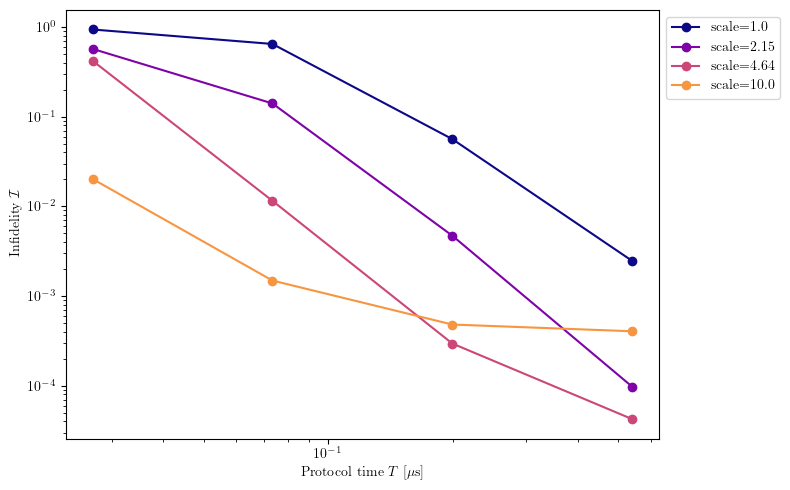

In [4]:
# Plot the fidelities
fig, ax0 = plt.subplots(1, 1, figsize = (8, 5))

for j in range(len(scales)):
    color = plt.get_cmap('plasma')(j / len(scales))
    ax0.plot(Times, 1-fids[j], marker='o', label=f'scale={np.round(scales[j], 2)}', color=color)
    
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_xlabel('Protocol time $T$ [$\mu$s]')
ax0.set_ylabel('Infidelity $\mathcal{I}$')
ax0.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()   